<a href="https://colab.research.google.com/github/diegoavelez/Sistema-de-Recomendacion-STEAM/blob/main/DiegoVelez_Proyecto_03_SR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

## Carga de Datos

Cargaremos las librerías a usar y los datos en formato JSON serán transformados a datasets para manipulación y uso durante el proyecto. Se harán algunas pruebas en los datasets resultantes para comprobar la integridad de los datos de manera básica.

In [1]:
#importamos las librerías a usar
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
from tqdm import tqdm

#librería surprise
!pip install surprise
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import NormalPredictor
from surprise import SVD
from surprise import BaselineOnly
from surprise.accuracy import rmse
from surprise import accuracy

#script para leer los datos en el formato json
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

     |████████████████████████████████| 11.8 MB 5.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630196 sha256=05e3cce564aca50a52f0d3842fa5adf9651f0cd7a64fa4be29856d9593b6d374
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
#cargamos los datos
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Aca apunta a la carpeta de google drive donde se guardaron los datos
root_dir = "/content/drive/MyDrive/DS Datasets"

Mounted at /content/drive


**Reviews**

In [3]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('/content/drive/MyDrive/DS Datasets/steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [4]:
data_reviews = pd.DataFrame(data_reviews)

In [5]:
#realizamos una prueba para mirar la integridad de los datos
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


In [6]:
data_reviews.tail()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
779302,Vidaar,783.5,353.0,252490,1,2013-12-11,Summary: Rust is a survival game created by Fa...,True,10217,NaN,NaN,NaN
779303,Nikolai Belinski,55.1,204.0,252490,1,2013-12-11,Coolest Game Eva,True,10218,NaN,NaN,NaN
779304,RancorZealot,203.5,173.0,252490,1,2013-12-11,Should you buy RUST? Uh... YES. The BEST Survi...,True,10219,76561197963920623,NaN,NaN
779305,Jerry,139.8,79.0,252490,1,2013-12-11,Great game!,True,10220,76561198042664856,NaN,NaN
779306,Helk,15375.0,98.0,252490,1,2013-12-11,I love this game!,True,10221,NaN,NaN,36.0


In [7]:
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

**Games**

In [8]:
data_games = []
for l in parse('/content/drive/MyDrive/DS Datasets/steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [9]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [10]:
data_games.tail()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",NaN,NaN
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,NaN,NaN
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,NaN,NaN
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",1 user reviews,NaN
32134,NaN,NaN,Maze Run VR,NaN,http://store.steampowered.com/app/681550/Maze_...,NaN,"[Early Access, Adventure, Indie, Action, Simul...",NaN,http://steamcommunity.com/app/681550/reviews/?...,"[Single-player, Stats, Steam Leaderboards, HTC...",4.99,True,681550,NaN,Positive,NaN


In [11]:
data_games[data_games.id == '252490']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
29692,Facepunch Studios,"[Action, Adventure, Indie, Massively Multiplay...",Rust,Rust,http://store.steampowered.com/app/252490/Rust/,2013-12-11,"[Early Access, Survival, Crafting, Multiplayer...",NaN,http://steamcommunity.com/app/252490/reviews/?...,"[Multi-player, MMO, Cross-Platform Multiplayer...",19.99,True,252490,Facepunch Studios,Very Positive,NaN


In [12]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

## Análisis Exploratorio de los Datos



### Información del dataset y sus columnas

La información fuente proviene de dos archivos para la construcción de los datasets: steam_reviews.json.gz y steam_games.json.gz. que fueron mapeados a los datasets data_reviews y data_games respectivamente para su manipulación durante el proyecto.



In [13]:
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779307 entries, 0 to 779306
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   username      779307 non-null  object 
 1   hours         776670 non-null  float64
 2   products      777741 non-null  float64
 3   product_id    779307 non-null  object 
 4   page_order    779307 non-null  int64  
 5   date          779307 non-null  object 
 6   text          779307 non-null  object 
 7   early_access  779307 non-null  bool   
 8   page          779307 non-null  int64  
 9   user_id       317340 non-null  object 
 10  compensation  14588 non-null   object 
 11  found_funny   120164 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 66.1+ MB


El dataset data_reviews contiene la información (779.307 instancias y 12 columnas) de las reseñas hechas por los usuarios a los diferentes juegos de la plataforma *Steam*.

Información de las columnas:

* **username**: es el nombre/alias de la persona que hizo la reseña.

* **hours**: indica la cantidad de horas de juego que ha hecho el usuario en el juego.

* **products**: indica la cantidad de juegos que tiene el usuario.

* **product_id**: identificador único del juego en *Steam*.

* **page_order**: orden de página de la reseña.

* **date**: indica la fecha de publicacion de la reseña.

* **text**: indica el texto que escribió el usuario sobre el juego asociado.

* **early_access**: indica si el usuario tuvo acceso al juego antes de su lanzamiento oficial. El acceso anticipado al juego puede ofrecer una experiencia diferente a la versión oficial, especialmente con los bugs.

* **page**: indica el número de página donde se encuentra la reseña.

* **user_id**: identificador del usuario que hizo la reseña. Tener en cuenta que el username no es identificador único.

* **compensation**: indica si el juego fue obtenido gratis o pago.

* **found_funny**: indica cuantos jugadores piensan que la reseña es divertida.


In [14]:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


El dataset data_games contiene información (32.135 instancias y 16 columnas) de los juegos de la plataforma *Steam*

Información de las columnas:

* **publisher**: indica la distribuidora del juego juego.

* **genres**: indica los géneros que mejor describen el juego.

* **app_name**: indica el nombre del juego en la plataforma.

* **title**: indica el título completo del juego.

* **url**: indica la dirección url en donde se encuentra el juego en *Steam*.

* **release_date**: indica la fecha de lanzamiento del juego.

* **tags**: indica los tags del juego, palabras claves.

* **discount_price**: indica si el juego tiene descuento en su precio.

* **reviews_url**: indica la dirección url donde se encuentran las reseñas del juego.

* **specs**: indica los requisitos para poder jugar al juego.

* **price**: indica el precio del juego.

* **early_access**: indica si se encuentra en early access (acceso anticipado) o no.

* **id**: indica el identificador único del juego

* **developer**: indica el desarrollador del juego.

* **sentiment**: indica la percepción del juego por parte de los usuarios.

* **metascore**: esto es un puntaje que otorga "metacritic" e indica que tan bueno es el juego y va de 0-100.

###Estadísticos de los datasets

*Reviews*

In [15]:
data_reviews.describe().T

,count,mean,std,min,25%,50%,75%,max
hours,776670.0,111.843832,390.145376,0.0,4.0,15.3,59.6,28164.0
products,777741.0,236.993936,486.034479,1.0,45.0,110.0,246.0,13540.0
page_order,779307.0,4.417743,2.897848,0.0,2.0,4.0,7.0,9.0
page,779307.0,893.581355,1928.272966,1.0,53.0,238.0,829.0,18371.0
found_funny,120164.0,7.713125,72.465816,1.0,1.0,1.0,3.0,6524.0


Dados los estadísticos encontrados se puede inferir la existencia de outliers para el número de horas jugadas para algunos juegos (min: 0 vs max: 28.164), como también en el número de productos que algunos usuarios tienen (min: 1 vs max: 13.540). Estos outliers se tendrán en cuenta a la hora de construir un calificador (rating) o a la hora de hacer limpieza de datos.





*Games*


In [16]:
data_games.describe().T

,count,mean,std,min,25%,50%,75%,max
discount_price,225.0,11.930533,17.492643,0.49,1.39,4.19,22.66,139.99


Para el caso del dataset que contiene la información de los juegos, el único campo numérico es el de descuento del precio, campo que posteriormente se tendrá en cuenta para eliminar en el modelo; considerando también que es un campo que tiene valores bastantes nulos y lo más adecuado, al igual que el metascore que también está ausente para la gran mayoría de los juegos 29.458/32.135.

###Limpieza y transformación de datos

*Reviews*

En el caso del dataset que contiene información de los reviews, se eliminarán las siguientes columnas que no aportan información al modelo de recomendación a construir. 

*  Page order: el orden de página no afecta el modelo de recomendación.
*  date: la fecha de elaboración del review no es relevante para el modelo en cuestión, se podría realizar un tratamiento con la fecha de lanzamiento en su lugar.
*  text: el texto del review no será analizado por este modelo, se asumirá que si un usuario realiza una review es porque es propietario del juego y el número de horas indicará qué tanto le gusta un juego.
*  page: el número de pagína no afecta el modelo de recomendación.
*  user_id: dado que esta campo tiene más de 400 mil valores nulos en el dataset, se elimina.
*  compensation, found_funny: dado que estos campos están relacionados con el texto del review y tienen muchos valores nulos no se tendrán en cuenta en el análisis del modelo.


In [17]:
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

In [18]:
#Eliminamos las columnas que no usaremos para el sistema
data_reviews.drop(['page_order','date','text','page','user_id','compensation','found_funny'], axis=1, inplace=True)

In [19]:
data_reviews.head()

,username,hours,products,product_id,early_access
0,Chaos Syren,0.1,41.0,725280,False
1,Ariman1,13.2,1386.0,328100,False
2,freakfantom,0.1,1706.0,725280,False
3,The_Cpt_FROGGY,7.8,2217.0,631920,False
4,the_maker988,8.2,18.0,35140,False


In [20]:
# Se eliminan los datos duplicados
data_reviews = data_reviews.drop_duplicates()
data_reviews.shape

(770620, 5)

In [21]:
data_reviews.isna().sum()

username           0
hours           2634
products        1553
product_id         0
early_access       0
dtype: int64

Dado el escaso número de valores nulos resultantes teniendo en cuenta el tamaño de dataset, se eliminarán los registros que tienen valores nulos de horas y de productos para facilidad en el análisis.

In [22]:
# Se eliminan los valores nulos faltantes del dataset data_reviews
data_reviews.dropna(inplace=True)

In [23]:
# Consultamos la cantidad de reseñas con early access, información que podría 
# ser relevante
data_reviews['early_access'].value_counts()

False    660591
True     105843
Name: early_access, dtype: int64

In [24]:
# Validamos nuevamente los valores nulos
data_reviews.isna().sum()

username        0
hours           0
products        0
product_id      0
early_access    0
dtype: int64

In [25]:
# ¿Cuántos usuarios tenemos?
print("Tenemos los datos de", len(data_reviews['username'].value_counts()), "usuarios diferentes")

Tenemos los datos de 537742 usuarios diferentes


Se tienen reseñas de 537.742 usuarios, siendo una cifra bastante grande a la hora de construir el modelo.

Steam permite a los usuarios devolver un juego si lo han jugado por menos de dos horas. Se considerará esta condición en el sistema de recomendación, es decir que las reseñas para juegos que tuvieron menos de dos horas no serán consideradas.

In [26]:
# Eliminamos los registros de reseñas con horas jugadas menores a 2
data_reviews.drop(data_reviews[data_reviews['hours'] <= 2].index, inplace = True)

In [27]:
# ¿Cuántas reseñas tenemos por usuario?
data_reviews.groupby(by='username').agg({'product_id': 'count', 'hours': 'sum'}).reset_index().sort_values('product_id',ascending=False)

,username,product_id,hours
4739,123,182,185978.3
16632,Alex,160,25787.3
188284,Matt,123,14991.4
57354,Chris,116,13598.1
210769,Nick,111,6871.2
...,...,...,...
172559,Li'l Sebastian,1,2071.1
172557,Li Xiaolong,1,43.2
172556,Li Hing Pirate,1,48.3
172555,Li,1,12.2


A pesar de que tenemos las reseñas de 470.084 usuarios, vamos a filtrar aquellos usuarios que solamente han realizado una reseña. De esta manera poder optimizar el filtro colaborativo que depende de los gustos de otros usuarios sobre varios títulos de juegos.

In [28]:
# Eliminamos los registros de usuarios que solamente han hecho una (1) reseña
data_reviews = data_reviews[data_reviews.duplicated(subset=['username'], keep=False)]
#revisamos el tamaño del dataset
data_reviews.shape

(250842, 5)

Se conservan entonces 250.842 registros de 770.620 que teníamos anteriormente. Conservando unicamente el 32,6% de los datos. Eso quiere decir que muchas de las reseñas que se tienen inicialmente son de usuarios que solamente han realizado una sola reseña (219.242).

##### Construyendo una calificación

Los datos utilizados para este sistema de recomendación son los del conjunto de datos de usuarios de Steam reformulados. Los datos no contienen explícitamente la calificación o preferencia de los usuarios hacia los juegos, sino que se expresan implícitamente por la cantidad de horas que los usuarios han jugado.

En el ejercicio asumiremos que la mediana del tiempo de juego puede darnos idea del interés que tiene cada jugador por cada juego. Dicho esto, compararemos el tiempo de juego de cada jugador con la mediana de las horas jugadas por todos los jugadores para ese juego. La mediana nos ayudará a tratar con los outliers de las horas jugadas, ya que esta medida estadística no es sensible a estos valores extremos.

Posteriormente, usaremos un algoritmo para asignar a cada jugador un rating entre 1 y 5 que nos ayude a crear nuestro modelo, como también que nos permita tener un escalado de datos para todos los jugadores.

In [29]:
# Calculamos la mediana de horas de cada juego con review
df_median_playtime = data_reviews.groupby('product_id').agg({'hours':np.median}).reset_index()
df_median_playtime.rename(columns={"product_id": "product_id", "hours": "median_hours"}, inplace=True)
df_median_playtime

,product_id,median_hours
0,10,5.85
1,100400,48.90
2,10090,31.65
3,100980,346.30
4,10100,27.10
...,...,...
8796,99400,3.45
8797,99410,73.40
8798,99700,6.50
8799,99900,36.75


In [30]:
# Ahora lo agregamos al dataset de reviews para luego calcular el rating
data_reviews_complete = data_reviews.merge(df_median_playtime, left_on='product_id', right_on='product_id',how='left')
data_reviews_complete

,username,hours,products,product_id,early_access,median_hours
0,The_Cpt_FROGGY,7.8,2217.0,631920,False,19.60
1,Vonder,2.7,264.0,35600,False,3.50
2,JKDarkseid,3.0,468.0,302390,False,5.00
3,MLGarbage,9.5,38.0,35140,False,16.00
4,Mia,31.4,149.0,631920,False,19.60
...,...,...,...,...,...,...
250837,Slavic Psycho,3.9,135.0,252490,True,162.85
250838,Tupac ;),1460.4,195.0,252490,True,162.85
250839,Vidaar,783.5,353.0,252490,True,162.85
250840,Nikolai Belinski,55.1,204.0,252490,True,162.85


In [31]:
# Calcular ratings para cada registro

data_reviews_complete['rating'] = 0

Rating_Conditions = [
    (data_reviews_complete['hours'] >= data_reviews_complete['median_hours']),
    np.logical_and(data_reviews_complete['hours'] < data_reviews_complete['median_hours'], data_reviews_complete['hours'] > data_reviews_complete['median_hours']*0.9),
    np.logical_and(data_reviews_complete['hours'] < data_reviews_complete['median_hours']*0.9, data_reviews_complete['hours'] > data_reviews_complete['median_hours']*0.8),
    np.logical_and(data_reviews_complete['hours'] < data_reviews_complete['median_hours']*0.8, data_reviews_complete['hours'] > data_reviews_complete['median_hours']*0.65),
    np.logical_and(data_reviews_complete['hours'] < data_reviews_complete['median_hours']*0.65, data_reviews_complete['hours'] > data_reviews_complete['median_hours']*0.5),
    np.logical_and(data_reviews_complete['hours'] < data_reviews_complete['median_hours']*0.5, data_reviews_complete['hours'] > data_reviews_complete['median_hours']*0.35),
    np.logical_and(data_reviews_complete['hours'] < data_reviews_complete['median_hours']*0.35, data_reviews_complete['hours'] > data_reviews_complete['median_hours']*0.2),
    np.logical_and(data_reviews_complete['hours'] < data_reviews_complete['median_hours']*0.2, data_reviews_complete['hours'] > data_reviews_complete['median_hours']*0.1),
    (data_reviews_complete['median_hours']*0.1 > data_reviews_complete['hours'])
]

Rating = [5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1]

data_reviews_complete['rating'] = np.select(Rating_Conditions, Rating)

data_reviews_complete

,username,hours,products,product_id,early_access,median_hours,rating
0,The_Cpt_FROGGY,7.8,2217.0,631920,False,19.60,2.5
1,Vonder,2.7,264.0,35600,False,3.50,3.5
2,JKDarkseid,3.0,468.0,302390,False,5.00,3.0
3,MLGarbage,9.5,38.0,35140,False,16.00,3.0
4,Mia,31.4,149.0,631920,False,19.60,5.0
...,...,...,...,...,...,...,...
250837,Slavic Psycho,3.9,135.0,252490,True,162.85,1.0
250838,Tupac ;),1460.4,195.0,252490,True,162.85,5.0
250839,Vidaar,783.5,353.0,252490,True,162.85,5.0
250840,Nikolai Belinski,55.1,204.0,252490,True,162.85,2.0


*Games*

Para el dataset que contiene la información de los juegos también se hará una limpieza de los datos, descartando aquellas columnas que su información no será tenido en cuenta para el sistema:

*  publisher: teniendo en cuenta que sus valores nulos son la cuarta parte de los juegos en el dataset, se elimina.
*  title: dado los valores nulos de esta columna, se trabajará con el campo app_name.
*  url: la dirección web del juego no es necesaria para el análisis.
*  tags: no se analizarán los tags durante este proyecto.
*  discount_price: al tener muchos valores nulos, no lo hace relevante.
*  reviews_url: la dirección de los reviews no aporta información valiosa al modelo.
*  specs: no se analizará este aspecto dentro del modelo.
*  early_access: se tendrá en cuenta esta variable en el otro dataset data_reviews.
*  sentiment: esta variable será sustituida por las horas de juego, donde a más horas jugadas más recomendado es un juego.
*  metascore: como la mayoría de los juegos no tiene un rating de Metascore, se elimina esta columna.


In [32]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

In [33]:
# Eliminamos las columnas que no serán usadas para el sistema
data_games.drop(['publisher','title','url','tags','discount_price','reviews_url','specs','early_access','sentiment','metascore'], axis=1, inplace=True)

In [34]:
# Miramos el dataset resultante
data_games.head()

,genres,app_name,release_date,price,id,developer
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,4.99,761140,Kotoshiro
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,Free To Play,643980,Secret Level SRL
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017-07-24,Free to Play,670290,Poolians.com
3,"[Action, Adventure, Casual]",弹炸人2222,2017-12-07,0.99,767400,彼岸领域
4,NaN,Log Challenge,NaN,2.99,773570,NaN


In [35]:
# Verificamos los valores nulos del dataset de juegos
data_games.isna().sum()

genres          3283
app_name           2
release_date    2067
price           1377
id                 2
developer       3299
dtype: int64

Analizaremos los casos donde los valores nulos son pocos y se eliminarán los registros donde no tenemos información de los géneros que puede ser necesaria para un análisis posterior.

In [36]:
# Consultamos los nulos de app_name
data_games[data_games['app_name'].isna()]

,genres,app_name,release_date,price,id,developer
74,NaN,NaN,NaN,19.99,NaN,NaN
2580,"[Action, Indie]",NaN,2014-08-26,NaN,317160,NaN


Como no tenemos el nombre de estos dos juegos se eliminarán por facilidad en el ejercicio.

In [37]:
# Ahora consultamos los nulos de la columna id 
data_games[data_games['id'].isna()]

,genres,app_name,release_date,price,id,developer
74,NaN,NaN,NaN,19.99,NaN,NaN
30961,"[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,2012-09-07,19.99,NaN,"Rocksteady Studios,Feral Interactive (Mac)"


Aquellos juegos que no tienen id no podrán ser enlazados con reseñas (reviews) para el análisis, por lo tanto se eliminan para no ser considerados en el modelo.

In [38]:
# Eliminamos los nulos vistos anteriormente y que no son muy pocos
data_games.dropna(axis=0, subset=['app_name','id','genres'], inplace = True )
data_games.isna().sum()

genres             0
app_name           0
release_date      18
price           1229
id                 0
developer        169
dtype: int64

In [39]:
# como los nulos de 'release_date' eran muy similares a los de genres, 
# se eliminan los 18 restantes por facilidad
data_games.dropna(axis=0, subset=['release_date'], inplace = True )

Se reemplazará el 'free to play' de los precios por precio 0 al igual que los nulos para facilitar el análisis del modelo. No se eliminarán estos juegos para considerar los juegos freemium, que aunque no tengan valores iniciales pueden tener compras dentro del juego.

In [40]:
# Se reemplazan los 'free to play' y los nulos por ceros
data_games['price'].replace(["Free to Play", np.NaN], np.zeros, inplace = True)

# Se reemplazan los desarrolladores nulos por el valor 'unknown'
data_games['developer'].replace([np.NaN], 'unknown', inplace = True)

In [41]:
# confirmamos los nulos
data_games.isna().sum()

genres          0
app_name        0
release_date    0
price           0
id              0
developer       0
dtype: int64

In [42]:
# Se explorarán los valores que tiene el campo 'release_date' ya que a la hora 
# de convertirlos a datetime han presentado problemas para la conversión
data_games['release_date'].value_counts().to_frame()

,release_date
2012-10-16,100
2017-08-31,92
2017-09-26,88
2017-07-25,78
2017-12-19,75
...,...
2021-12-31,1
2014-05-04,1
2018-12-20,1
1999-03-22,1


Efectivamente luego de la revisión exhaustiva de los valores únicos del campo 'release_date' se hace necesaria una limpieza de los datos para tener la información de manera homogénea. La cantidad de valores especiales es mayor a 20 y son casos particulares.

Para aquellos valores de fechas que dicen que será liberado pronto o no tiene fecha específica entonces se llevarán a valores nulos para eliminarlos del dataset.

En su lugar, para valores con fechas que no están en el formato YYYY-MM-DD se escribirá el primer día del mes de la fecha consignada.

In [43]:
# Se reemplazarán por NaN los valores que no tienen fecha específica.
data_games['release_date'].replace(['Coming Soon','Coming soon','coming soon','TBA','TBD',
                                    'SOON','Soon','When it\'s done','Coming Soon!',
                                    'coming soon','Not yet available','Release Date TBA',
                                    'When it is finished','Please wait warmly',
                                    'Coming soon..','SOON™','0̵1̴0̵0̶1̷0̶0̵0̴ ̴0̶0̶1̶1̶0̷0̶1̵1̴ ̸0̶0̶1̶1̵0̶1̷0̴0̵ ̴0̶1̷0̸1̵0̷0̴1̶0̴ ̴0̷0̴1̷1̶0̶1̵1̷1̵ ̵',
                                    'Early Access Starting Soon!','Soon™','Demo is available now!',
                                    'Demo coming soon.','soon','Soon..','Coming Soon/Próximamente',
                                    'To Be Announced','C\'est bientôt...                    (ou pas)',
                                    'To be announced','Datachunks conflicted. Be vigiliant.',
                                    'Play Beta in demo!','"""Soon"""','Hitting Early Access in 2017',
                                    'Comming Soon','预热群52756441','When it\'s done!',
                                    'Early Access soon','Beta测试已开启','When it is ready',
                                    'early Access','early access','14 July','To be Announced'], np.NaN, inplace = True)

In [44]:
data_games.isna().sum()

genres            0
app_name          0
release_date    103
price             0
id                0
developer         0
dtype: int64

In [45]:
"""
Ahora tenemos 103 valores nulos en las fechas de lanzamiento que serán eliminados
porque no es posible sacarlos con la información disponible.
Siguiente, se reemplazarán las fechas por el formato indicado para cada caso especial
"""

data_games.dropna(axis=0, subset=['release_date'], inplace = True )

# Años
data_games['release_date'].replace(['2016'], '2016-01-01', inplace = True)
data_games['release_date'].replace(['2017'], '2017-01-01', inplace = True)
data_games['release_date'].replace(['2018'], '2018-01-01', inplace = True)
# 2009
data_games['release_date'].replace(['Jun 2009'], '2009-06-01', inplace = True)
data_games['release_date'].replace(['Sep 2009'], '2009-09-01', inplace = True)
data_games['release_date'].replace(['Oct 2009'], '2009-10-01', inplace = True)
# 2010
data_games['release_date'].replace(['Jan 2010'], '2010-01-01', inplace = True)
data_games['release_date'].replace(['Mar 2010'], '2010-03-01', inplace = True)
data_games['release_date'].replace(['Jul 2010'], '2010-07-01', inplace = True)
data_games['release_date'].replace(['Oct 2010'], '2010-10-01', inplace = True)
# 2011
data_games['release_date'].replace(['Feb 2011'], '2011-02-01', inplace = True)
# 2012
data_games['release_date'].replace(['Dec 2012'], '2012-12-01', inplace = True)
# 2013
data_games['release_date'].replace(['Feb 2013'], '2013-02-01', inplace = True)
# 2014
data_games['release_date'].replace(['May 2014'], '2014-05-01', inplace = True)
data_games['release_date'].replace(['Jul 2014'], '2014-07-01', inplace = True)
data_games['release_date'].replace(['Aug 2014'], '2014-08-01', inplace = True)
data_games['release_date'].replace(['Sep 2014'], '2014-09-01', inplace = True)
data_games['release_date'].replace(['Nov 2014'], '2014-11-01', inplace = True)
# 2015
data_games['release_date'].replace(['Jan 2015'], '2015-01-01', inplace = True)
data_games['release_date'].replace(['Feb 2015'], '2015-02-01', inplace = True)
data_games['release_date'].replace(['Apr 2015'], '2015-04-01', inplace = True)
data_games['release_date'].replace(['May 2015'], '2015-05-01', inplace = True)
data_games['release_date'].replace(['Jun 2015'], '2015-06-01', inplace = True)
data_games['release_date'].replace(['Aug 2015'], '2015-08-01', inplace = True)
# 2016
data_games['release_date'].replace(['Apr 2016'], '2016-04-01', inplace = True)
data_games['release_date'].replace(['Jun 2016','June 2016'], '2016-06-01', inplace = True)
data_games['release_date'].replace(['Jul 2016'], '2016-07-01', inplace = True)
data_games['release_date'].replace(['Oct 2016'], '2016-10-01', inplace = True)
data_games['release_date'].replace(['Nov 2016'], '2016-11-01', inplace = True)
# 2017
data_games['release_date'].replace(['Jan 2017','January 2017','Q1 2017',
                                    'Hitting Early Access in 2017','Q1 (ish), 2017',
                                    'Late 2016 - Early 2017','2017 Q1','Early 2017'],
                                    '2017-01-01', inplace = True)
data_games['release_date'].replace(['Apr 2017','Q2 2017','Spring 2017'],
                                   '2017-04-01', inplace = True)
data_games['release_date'].replace(['21 Jun, 2017'], '2017-06-21', inplace = True)
data_games['release_date'].replace(['Jul 2017','TBA 2017','Coming Q3 2017',
                                    'Summer 2017','Coming 2017'], '2017-07-01', inplace = True)
data_games['release_date'].replace(['Aug 2017','August 2017'], '2017-08-01', inplace = True)
data_games['release_date'].replace(['Oct 2017','October 2017','2017 Q4', 'Fall 2017',
                                    'Q4 2017','Coming Fall 2017'], '2017-10-01', inplace = True)
data_games['release_date'].replace(['Nov 2017'], '2017-11-01', inplace = True)
data_games['release_date'].replace(['Dec 2017','December 2017','End 2017',
                                    'When it\'s done (2017)','Coming late 2017',
                                    'Winter 2017'], '2017-12-01', inplace = True)
# 2018
data_games['release_date'].replace(['Jan 2018','January 2018','2018 early',
                                    '2018 [Now get free Pre Alpha]','2018年初頭発売予定',
                                    'Январь 2018','First quarter of 2018','1st Quarter 2018',
                                    'Q1 2018','Early 2018','Coming Q1 2018',
                                    'Q1, 2018','Q1,2018','2018年1月'],'2018-01-01', inplace = True)
data_games['release_date'].replace(['Feb 2018'],'2018-02-01', inplace = True)
data_games['release_date'].replace(['Mar 2018','Spring 2018','Early Spring 2018'],
                                   '2018-03-01', inplace = True)
data_games['release_date'].replace(['Q2 2018','Q2 2018 (Tentative)'],'2018-04-01', inplace = True)
data_games['release_date'].replace(['August 2018','H2 2018'],'2018-08-01', inplace = True)
data_games['release_date'].replace(['Fall 2018'],'2018-09-01', inplace = True)
data_games['release_date'].replace(['Winter 2018'],'2018-12-01', inplace = True)

# 2019
data_games['release_date'].replace(['January 2019'],'2019-01-01', inplace = True)
data_games['release_date'].replace(['Jun 2019'],'2019-06-01', inplace = True)


In [46]:
# Se convertirá la fecha de lanzamiento a objeto datetime para su manipulación
# posterior en el modelo
data_games['release_date'] = pd.to_datetime(data_games['release_date'])
data_games['release_date'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  after removing the cwd from sys.path.


count                   28729
unique                   3276
top       2012-10-16 00:00:00
freq                      100
first     1983-06-19 00:00:00
last      2021-12-31 00:00:00
Name: release_date, dtype: object

In [47]:
# comprobamos el número de registros resultante
data_games.shape

(28729, 6)

De los 32.135 registros iniciales terminamos con 28.729, conservando el 89,4% de los datos iniciales del dataset data_games luego del tratamiento de datos


####Información Adicional y gráficos

In [48]:
# Agregamos el nombre del juego al dataset de reviews para consultas posteriores
data_reviews_complete = data_reviews_complete.merge(data_games[['id', 'app_name']],
                                                    how = 'left', left_on = 'product_id', right_on = 'id').drop(columns = ['id'])
data_reviews_complete.head()

,username,hours,products,product_id,early_access,median_hours,rating,app_name
0,The_Cpt_FROGGY,7.8,2217.0,631920,False,19.6,2.5,Somewhere on Zibylon
1,Vonder,2.7,264.0,35600,False,3.5,3.5,Big Brain Wolf
2,JKDarkseid,3.0,468.0,302390,False,5.0,3.0,Necronomicon: The Dawning of Darkness
3,MLGarbage,9.5,38.0,35140,False,16.0,3.0,Batman: Arkham Asylum Game of the Year Edition
4,Mia,31.4,149.0,631920,False,19.6,5.0,Somewhere on Zibylon


In [49]:
# Exploración de las reseñas
print("Número de juegos con reviews:", len(data_reviews_complete['app_name'].value_counts()))
print("Número de reviews para cada juego:")
data_reviews_complete['app_name'].value_counts()

Número de juegos con reviews: 8714
Número de reviews para cada juego:


Team Fortress 2                           4267
Rust                                      2804
Fallout 4                                 2378
Borderlands 2                             2368
Portal 2                                  1952
                                          ... 
Moorhuhn: Tiger and Chicken                  1
Robin of Loxley the Legend of Sherwood       1
Voxelaxy                                     1
Princess Edge - Dragonstone                  1
Terminal Velocity                            1
Name: app_name, Length: 8714, dtype: int64

Contando los valores del dataframe data_reviews_complete, tenemos información de 8.714 juegos. También se observa que muchos de ellos tienen pocos reviews que debe considerarse para el sistema de recomendación.

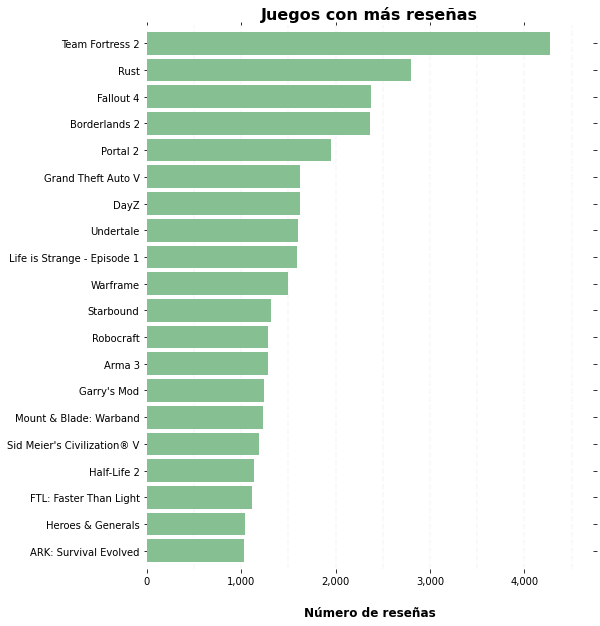

In [50]:
# Gráficamente los juegos top 20 con más reseñas
ax = data_reviews_complete['app_name'].value_counts()[:20].sort_values(ascending=True).plot(kind='barh', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Sin líneas visibles
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Marcas
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Título
ax.set_title("Juegos con más reseñas", weight='bold', size=16)

# Dibujar líneas del eje vertical
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Etiqueta del eje x
ax.set_xlabel("Número de reseñas", labelpad=20, weight='bold', size=12)

# Etiqueta del eje y
ax.set_ylabel("",labelpad=20, weight='bold', size=12)

# Formato de la etiqueta del eje y
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

In [51]:
# Comenzar un nuevo dataframe que guarde información agrupada por juego y las reseñas

reviewed_games = data_reviews_complete.groupby('app_name').count()

# eliminamos las columnas y usamos el conteo de username como el número de 
# reviews que tiene cada juego
reviewed_games = reviewed_games[['username']]
reviewed_games.columns = ['review_count']

# construir la columna de horas jugadas por juego
reviewed_games['total_hours'] = (data_reviews_complete.groupby('app_name').sum()['hours'])

# calcular las horas promedio
reviewed_games['average_hours'] = (reviewed_games['total_hours']/ reviewed_games['review_count'])

# calcular el rating promedio por juego
reviewed_games['average_rating'] = (data_reviews_complete.groupby('app_name').sum()['rating'] / reviewed_games['review_count'])

reviewed_games = reviewed_games.reset_index()

# Agregamos el id del juego al dataset para consultas posteriores
reviewed_games = reviewed_games.merge(data_games[['id', 'app_name']],
                                                    how = 'left', left_on = 'app_name', right_on = 'app_name')

print(reviewed_games.shape)
reviewed_games.head()

(8726, 6)


,app_name,review_count,total_hours,average_hours,average_rating,id
0,! That Bastard Is Trying To Steal Our Gold !,2,9.3,4.650000,4.750000,449940
1,"""Glow Ball"" - The billiard puzzle game",3,13.1,4.366667,4.833333,388390
2,#monstercakes,3,105.9,35.300000,4.333333,614910
3,$1 Ride,4,15.0,3.750000,4.625000,508290
4,- Arcane RERaise -,2,6.6,3.300000,4.750000,603770


In [52]:
# Eliminamos los registros con número de reseñas menores a 50 para considerar solamente los juegos más populares
reviewed_games.drop(reviewed_games[reviewed_games['review_count'] < 50].index, inplace = True)

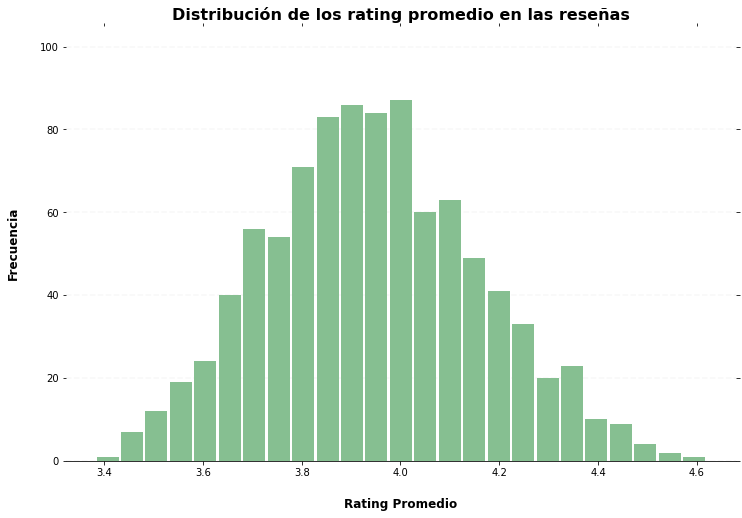

In [53]:
# Miremos la distribución de ratings promedio de los juegos
ax = reviewed_games['average_rating'].hist(bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

# Sin bordes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Dibujar líneas horizontales
vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Título
ax.set_title("Distribución de los rating promedio en las reseñas", weight='bold', size=16)

# Etiqueta del eje x
ax.set_xlabel("Rating Promedio", labelpad=20, weight='bold', size=12)

# Etiqueta del eje y
ax.set_ylabel("Frecuencia", labelpad=20, weight='bold', size=12)

# Formato de la etiqueta del eje y
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

Luego de hacer el filtro por los juegos más populares del dataset reviewed_games, la distribución de los rating es casi normal. La mayoría de los casos se concentra entre 3.9 y 4.1 

La calificación de 4.0 puede darnos idea de que las horas de juego de la mayoría de las personas que han hecho reseñas (reviews) han jugado entre el 100% y el 80% de la mediana de las horas jugadas, de acuerdo al calificador implícito que fue construido a partir de las horas jugadas. 




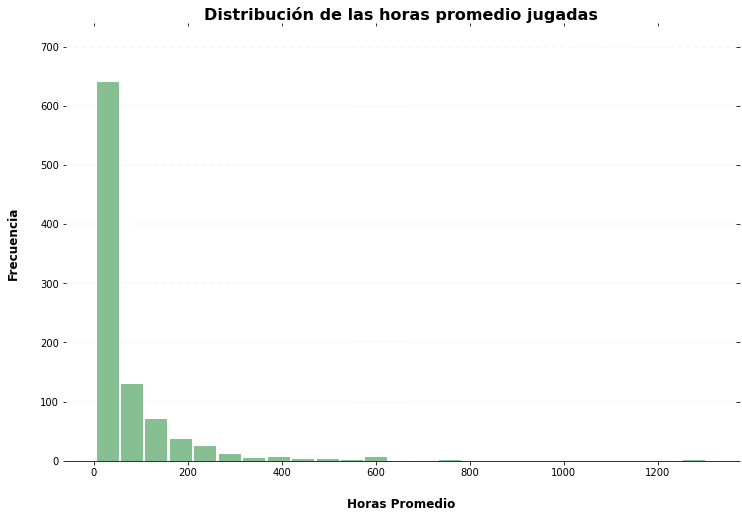

In [54]:
# Miremos la distribución de horas promedio de los juegos
ax = reviewed_games['average_hours'].hist(bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

# Sin bordes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

    # Ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Dibujar líneas horizontales
vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Título
ax.set_title("Distribución de las horas promedio jugadas", weight='bold', size=16)

# Etiqueta del eje x
ax.set_xlabel("Horas Promedio", labelpad=20, weight='bold', size=12)

# Etiqueta del eje y
ax.set_ylabel("Frecuencia", labelpad=20, weight='bold', size=12)

# Formato de la etiqueta del eje y
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

Se aprecia por la gráfica que la mayoría de los juegos tienen menos de 50 horas jugadas, lo cual se deduce que es un comportamiento normal, aún para los juegos más populares.

In [55]:
# Consultamos los juegos con más horas jugadas del dataset resultante
reviewed_games.sort_values(["total_hours"], ascending=False)

,app_name,review_count,total_hours,average_hours,average_rating,id
7206,Team Fortress 2,4267,3307529.5,775.141669,3.537146,440
6106,Rust,2804,1136025.7,405.144686,3.632133,252490
8245,Warframe,1502,844912.7,562.525100,3.504993,230410
553,Arma 3,1281,780403.6,609.214364,3.561280,107410
3065,Garry's Mod,1238,771111.6,622.868821,3.599758,4000
...,...,...,...,...,...,...
2472,Emily is Away Too,56,239.7,4.280357,4.196429,523780
4762,Morphopolis,52,225.1,4.328846,4.355769,314020
8416,Woodle Tree Adventures,50,214.4,4.288000,4.480000,299460
735,Back to the Future: The Game,57,203.0,3.561404,4.447368,31290


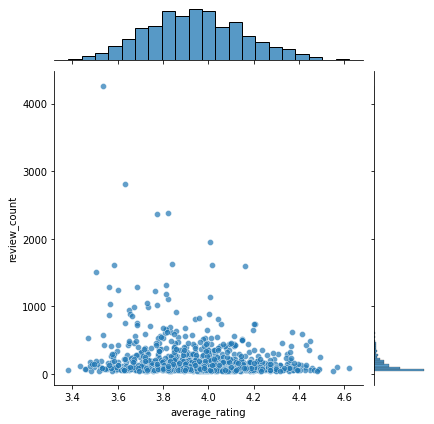

In [56]:
# Creamos un joint plot para ver la distribución del número de reviews vs rating promedio
sns.jointplot(x='average_rating',y='review_count',data=reviewed_games,alpha=0.7)

A partir de la gráfica se puede inferir que la distribución de reseñas está concentrada en aquellos juegos que no tienen muchas reseñas y que su rating se distribuye de manera casi normal como lo habíamos visto anteriormente.

Los valores atípicos para algunos juegos muy populares indican que muchas de las reseñas a estos juegos son dados cuando aún no se han completado la mediana de las horas jugadas que es cuando tenemos un rating de 5 según nuestro calificador.




####Análisis de géneros

In [57]:
# Se cambia el tipo de dato de la columna genres a tipo string para realizar 
# el reemplazo de los caracteres [] y la comilla simpl
data_games['genres'] = data_games['genres'].astype(str)
data_games['genres'] = data_games['genres'].str.replace('[','', regex=True)
data_games['genres'] = data_games['genres'].str.replace(']','', regex=True)
data_games['genres'] = data_games['genres'].str.replace('\'','', regex=True)
data_games['genres'] = data_games['genres'].str.replace(' ','', regex=True)

data_games

,genres,app_name,release_date,price,id,developer
0,"Action,Casual,Indie,Simulation,Strategy",Lost Summoner Kitty,2018-01-04,4.99,761140,Kotoshiro
1,"FreetoPlay,Indie,RPG,Strategy",Ironbound,2018-01-04,Free To Play,643980,Secret Level SRL
2,"Casual,FreetoPlay,Indie,Simulation,Sports",Real Pool 3D - Poolians,2017-07-24,<built-in function zeros>,670290,Poolians.com
3,"Action,Adventure,Casual",弹炸人2222,2017-12-07,0.99,767400,彼岸领域
5,"Action,Adventure,Simulation",Battle Royale Trainer,2018-01-04,3.99,772540,Trickjump Games Ltd
...,...,...,...,...,...,...
32129,"Action,Adventure,Casual,Indie",Kebab it Up!,2018-01-04,1.99,745400,Bidoniera Games
32130,"Casual,Indie,Simulation,Strategy",Colony On Mars,2018-01-04,1.99,773640,"Nikita ""Ghost_RUS"""
32131,"Casual,Indie,Strategy",LOGistICAL: South Africa,2018-01-04,4.99,733530,Sacada
32132,"Indie,Racing,Simulation",Russian Roads,2018-01-04,1.99,610660,Laush Dmitriy Sergeevich


Se aprecia que ahora la columna de genres no tiene las llaves, ni espacios para el análisis.

In [58]:
# Creamos un dataframe donde guardaremos los géneros de cada juego para luego graficar

df_genres = data_games['genres'].apply(lambda genrelist : str(genrelist).split(","))
df_genres = pd.Series(df_genres).apply(frozenset).to_frame(name='givengenres')

for givengenres in frozenset.union(*df_genres.givengenres):
    df_genres[givengenres] = df_genres.apply(lambda _: int(givengenres in _.givengenres), axis=1)

df_genres.drop('givengenres',axis=1,inplace=True)
df_genres['id']=data_games['id']
df_genres = pd.merge(data_games,df_genres,on='id')


genre_columns= ['Action','Simulation', 'Sports', 'Racing', 'Casual', 'Strategy',
                'RPG', 'MassivelyMultiplayer', 'Indie', 'FreetoPlay',
                'Adventure', 'EarlyAccess','Education', 'Design&amp;Illustration',
                'Utilities','PhotoEditing','Animation&amp;Modeling','Accounting',
                'WebPublishing','AudioProduction','SoftwareTraining','VideoProduction']
                

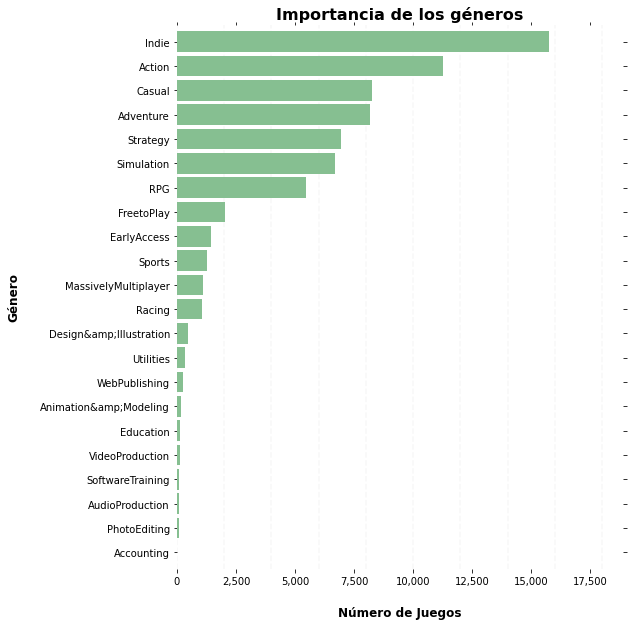

In [59]:
# Generamos un gráfico para ver la importancia de los géneros en los reviews
ax = df_genres[genre_columns].sum().sort_values(ascending=True).plot(kind='barh', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Sin líneas visibles
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Título
ax.set_title("Importancia de los géneros", weight='bold', size=16)

# Dibujar líneas del eje vertical
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Etiqueta del eje x
ax.set_xlabel("Número de Juegos", labelpad=20, weight='bold', size=12)

# Etiqueta del eje y
ax.set_ylabel("Género", labelpad=20, weight='bold', size=12)

# Formato de la etiqueta del eje y
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

Por la gráfica se aprecia que el género con más número de juegos es el indie, que tiene sentido porque la plataforma STEAM precisamente promueve este tipo de juegos desde sus inicios. Los otros géneros Action, Casual y Adventure son los géneros que siguen en orden de importancia y comunes en la mayoría de los juegos.

## Modelo de Machine Learning - Sistema de Recomendación

Para desarrollar el Sistema de Recomendación de este proyecto, usaremos el método de filtro colaborativo basado en el usuario y sus interacciones con el juego.

El filtro colaborativo no requiere ninguna información sobre los artículos o los usuarios para ofrecer recomendaciones. Sólo utiliza las interacciones entre los usuarios y los artículos expresadas por el calificador construído.

El filtro colaborativo se basa en el principio de que si a dos personas les han gustado las mismas cosas en el pasado, si a una de ellas le gusta algo nuevo, es probable que a la otra también le guste. La ventaja del método de filtro colaborativo es que el algoritmo no necesita entender o procesar el contenido de los artículos que recomienda.


In [60]:
# Prueba
data_reviews_complete.head()

,username,hours,products,product_id,early_access,median_hours,rating,app_name
0,The_Cpt_FROGGY,7.8,2217.0,631920,False,19.6,2.5,Somewhere on Zibylon
1,Vonder,2.7,264.0,35600,False,3.5,3.5,Big Brain Wolf
2,JKDarkseid,3.0,468.0,302390,False,5.0,3.0,Necronomicon: The Dawning of Darkness
3,MLGarbage,9.5,38.0,35140,False,16.0,3.0,Batman: Arkham Asylum Game of the Year Edition
4,Mia,31.4,149.0,631920,False,19.6,5.0,Somewhere on Zibylon


In [61]:
# Prueba
reviewed_games.head()

,app_name,review_count,total_hours,average_hours,average_rating,id
16,"10,000,000",61,870.1,14.263934,4.237705,227580
17,100% Orange Juice,229,15877.6,69.334498,3.858079,282800
50,20XX,63,2003.4,31.800000,3.912698,322110
73,60 Seconds!,52,513.0,9.865385,3.961538,368360
121,A Hat in Time,176,3289.8,18.692045,4.221591,253230


In [62]:
#Preparamos el dataset que será utilizado por la librería Surprise
steam = data_reviews_complete[['username', 'product_id', 'rating']]
steam.shape

(251091, 3)

In [63]:
# Se prepararán los datos para tener solamente aquellos juegos que tienen más de 50 reviews
steam_idx = steam['product_id'].apply(lambda x: x in reviewed_games['id'].values)
steam = steam[steam_idx]
steam.shape

(193810, 3)

In [64]:
# se eliminan los reviews duplicados, manteniendo los más recientes
steam.drop_duplicates(subset = ['username', 'product_id'],
                     keep = 'last', inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [65]:
steam.shape

(192056, 3)

Luego del filtro de las reseñas que sean superiores a 50 para cada juego, quedamos con un dataset de 192.056 reseñas

In [66]:
# tranformar el dataset compatible con Surprise 
reader = Reader(line_format='user item rating', rating_scale=(1, 5))
data = Dataset.load_from_df(steam[['username', 'product_id', 'rating']],reader)

In [67]:
# Entrenamos sobre todo el dataset, que luego tendrá validación cruzada por los algoritmos
trainset = data.build_full_trainset()

In [68]:
# Miramos el número de juegos y usuarios en el dataset de entrenamiento
print('Número de usuarios: ', trainset.n_users, '\n')
print('Número de juegos: ', trainset.n_items, '\n')

Número de usuarios:  77249 

Número de juegos:  938 



####*Algoritmos básicos usando la librería Surprise*

*BaselineOnly*

Algoritmo que predice un estimado base dado un usuario y un juego

*NormalPredictor*

Algoritmo que predice un rating aleatorio basado en la distributicón del set de entrenamiento, que asume como normal. Es uno de los algoritmos más básicos. 

*SVD*

Algoritmo equivalente a la Matriz de Factorización Probabilístico.

In [69]:
benchmark = []
# Iteramos sobre varios algoritmos para encontrar el óptimo para el modelo
# Usaremos RMSE como métrica de exactitud del modelo

algorithms = [SVD(), NormalPredictor(), BaselineOnly()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    
    # Realizamos validación cruzada
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
        
    # Obtenemos los resultados y los guardamos en la lista de benchmark
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fbb00ce4350>, <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7fbb00cbde90>, <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x7fbb00cbde50>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fbb00ce4350>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fbb00ce4350> 


Starting:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7fbb00cbde90>
Done:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7fbb00cbde90> 


Starting:  <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x7fbb00cbde50>
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Done:  <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x7fbb00cbde50> 



	DONE



In [70]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,1.308331,0.984576,0.674994
SVD,1.330806,8.735506,0.938480
NormalPredictor,1.719978,0.292510,0.907641


Para el caso de los tres algoritmos evaluados (BaselineOnly, SVD y NormalPredictor) el mejor calificado (RMSE y tiempo) fue BaselineOnly. 

Error cuadrático medio: Al igual que el MAE, el error cuadrático medio también tiene en cuenta el signo negativo, pero elevando al cuadrado las predicciones. El MSE no funciona bien cuando tenemos valoraciones en diferentes escalas, por esta razón, tomamos la raíz del error cuadrático medio para obtener el RMSE. Esto normaliza el resultado medio a la misma escala. El RMSE también es mejor para tratar los valores atípicos.


*SVD con GridSearch*

La descomposición del valor singular (SVD) es un método del álgebra lineal que se ha utilizado generalmente como técnica de reducción de la dimensionalidad en Machine Learning. La SVD es una técnica de factorización de matrices que reduce el número de características de un conjunto de datos reduciendo la dimensión del espacio de N dimensiones a K dimensiones (donde K<N). En el contexto del sistema de recomendación, el algoritmo SVD se utiliza como una técnica de filtro colaborativo. Utiliza una estructura matricial en la que cada fila representa un usuario y cada columna un artículo. Los elementos de esta matriz son las valoraciones que los usuarios dan a los artículos.

In [71]:
'''
# Mejoraremos los parametros del algoritmo SVD para evaluarlo
param_grid = {'n_factors':[20, 50, 100],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
               'reg_all': [0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, n_jobs = -1, measures=["rmse"], 
                  refit=True, cv=5)

gs.fit(data)

training_parameters = gs.best_params["rmse"]

#Imprimir los mejores parámetros
print("MEJOR RMSE: \t", gs.best_score["rmse"])
print("MEJORES params: \t", gs.best_params["rmse"])
'''

# Se deja una copia de la imagen para un procesamiento más rápido del notebook

'\n# Mejoraremos los parametros del algoritmo SVD para evaluarlo\nparam_grid = {\'n_factors\':[20, 50, 100],\'n_epochs\': [5, 10], \'lr_all\': [0.002, 0.005],\n               \'reg_all\': [0.4, 0.6]}\n\ngs = GridSearchCV(SVD, param_grid, n_jobs = -1, measures=["rmse"], \n                  refit=True, cv=5)\n\ngs.fit(data)\n\ntraining_parameters = gs.best_params["rmse"]\n\n#Imprimir los mejores parámetros\nprint("MEJOR RMSE: \t", gs.best_score["rmse"])\nprint("MEJORES params: \t", gs.best_params["rmse"])\n'

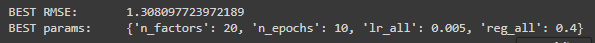

Luego de la optimización de parametros para el algoritmo SVD se pudo alcanzar un RMSE de 1.3081, superando el BaselineOnly inicial por muy poco.

In [72]:
# Entrenamos el modelo con los parametros encontrados
algo_svd = SVD(n_factors = 20, n_epochs = 10, lr_all = 0.005, reg_all = 0.4)
algo_svd.fit(trainset)

In [73]:
# probamos algunas predicciones con algunos ratings que un usuario ya ha realizado
user1 = "Mia"
review_user = data_reviews_complete.loc[data_reviews_complete.username==user1]
review_user['rating_svd'] = review_user['product_id'].apply(lambda x: algo_svd.predict(user1, x).est)
review_user.head(20).sort_values('rating_svd',ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,username,hours,products,product_id,early_access,median_hours,rating,app_name,rating_svd
65324,Mia,20.1,114.0,207610,False,15.35,5.0,The Walking Dead,4.327304
135328,Mia,5.4,412.0,55110,False,10.60,3.0,Red Faction®: Armageddon™,4.110868
211805,Mia,47.7,114.0,208650,False,36.30,5.0,Batman™: Arkham Knight,4.093851
46668,Mia,6.5,107.0,104900,False,8.15,3.5,ORION: Prelude,4.049518
31754,Mia,463.0,59.0,261640,False,45.10,5.0,Borderlands: The Pre-Sequel,4.020164
82945,Mia,16.1,301.0,245170,False,16.50,4.5,Skullgirls,4.006286
4,Mia,31.4,149.0,631920,False,19.60,5.0,Somewhere on Zibylon,3.981327
51817,Mia,8.9,54.0,362810,False,8.90,5.0,Fighties,3.981327
81293,Mia,8.9,149.0,521330,True,8.90,5.0,Tuebor: I Will Defend,3.981327
164466,Mia,7.6,116.0,346140,False,10.40,3.5,Hidden Object Bundle 5 in 1,3.981327


Luego de la optimización de paramétros para el algoritmo SVD, comprobamos que algunos ratings están con diferencias incluso de un (1) punto con respecto al rating que realmente el usuario tiene, lo cual indica que falta mucho por mejorar en las estimaciones.

In [74]:
# Ahora la predicción para juegos nuevos
games = data_reviews_complete.product_id.unique()
new_games = [product_id for product_id in games if product_id not in review_user.product_id.values]
print('Total de Productos ',len(games))
print('Productos con reseñas    ', len(review_user))
print('Productos sin reseñas',len(new_games))

reco = pd.DataFrame(new_games, columns=['product_id'])
reco['rating_svd'] = reco['product_id'].apply(lambda x: algo_svd.predict(user1, x).est)
reco = reco.merge(data_games[['id', 'app_name']], how = 'left', left_on = 'product_id', right_on = 'id').drop(columns = ['id'])

reco.head(10).sort_values('rating_svd',ascending=False)

Total de Productos  8801
Productos con reseñas     10
Productos sin reseñas 8791


,product_id,rating_svd,app_name
2,35140,4.214270,Batman: Arkham Asylum Game of the Year Edition
0,35600,3.981327,Big Brain Wolf
1,302390,3.981327,Necronomicon: The Dawning of Darkness
3,267670,3.981327,Realms of Arkania 1 - Blade of Destiny Classic
4,506510,3.981327,Shadows of Adam
5,399660,3.981327,Battle Battalions
6,328100,3.981327,Gunspell - Steam Edition
7,544190,3.981327,Book Series - Alice in Wonderland
8,452570,3.981327,Battle Chef Brigade
9,365560,3.981327,Battle of the Bulge


Para juegos nuevos, la recomendación parece acorde a los gustos del usuario basado en sus ratings de juegos anteriores, lo cual demuestra que el sistema funciona bien pero debe seguir ajustándose. Sin embargo, el score es casi el mismo para muchos juegos, lo cual indica que todavía debe afinarse.

*Optimizamos BaselineOnly con GridSearchCV*

El método elegido es el ALS (Alternative Least Squares), este es un algoritmo de factorización de matrices que utiliza los mínimos cuadrados alternos con la regularización ponderada de Lambda (ALS-WR).

ALS utiliza la factorización matricial, que consiste básicamente en tomar una matriz grande y factorizarla en matrices más pequeñas cuyo producto es igual al original. Para nuestro caso de sistema de recomendación colaborativo con datos implícitos, la factorización matricial reduce matemáticamente la matriz original "todos los usuarios frente a todos los juegos" en matrices más pequeñas "todos los usuarios frente a algunas características" y "todos los juegos frente a algunas características". Las características mencionadas se aprenden de los datos y no representan necesariamente ningún metadato real.

El método ALS debe descubrir los factores latentes que explican las valoraciones observadas de usuario a juego y trata de encontrar los pesos óptimos de los factores para minimizar los mínimos cuadrados entre las valoraciones predichas y las reales.

In [75]:
'''
param_grid = {'bsl_options': {'method': ['als','sgd'],
                              'reg_i': [8, 9, 10, 11, 12], # lambda 2
                              'reg_u': [3, 4, 5, 6, 7],# lambda 3
                             }   
             }

gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(data)

# Mejor RMSE
print(gs.best_score['rmse'])

# imprimir la combinación de parámetros que dan el mejor RMSE
print(gs.best_params['rmse'])
'''

# Se adjunta una imagen de los resultados para optimizar el tiempo de ejecución

"\nparam_grid = {'bsl_options': {'method': ['als','sgd'],\n                              'reg_i': [8, 9, 10, 11, 12], # lambda 2\n                              'reg_u': [3, 4, 5, 6, 7],# lambda 3\n                             }   \n             }\n\ngs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=3, n_jobs=-1)\ngs.fit(data)\n\n# Mejor RMSE\nprint(gs.best_score['rmse'])\n\n# imprimir la combinación de parámetros que dan el mejor RMSE\nprint(gs.best_params['rmse'])\n"

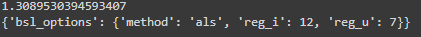


Aún cuando se optimizan los parámetros del algoritmo, sigue teniendo un RMSE que ya habíamos calculado de 1.3090, incluso empeora por algunos decimales.

In [76]:
bsl_options = {'method': 'als', 'reg_i': 12, 'reg_u': 7}
algo_bsl = BaselineOnly(bsl_options=bsl_options)
# Entrenamos con el set de entrenamiento
algo_bsl.fit(trainset)

Estimating biases using als...


In [77]:
# de nuevo probamos ratings conocidos con este nuevo algoritmo
user1 = "Mia"
review_user = data_reviews_complete.loc[data_reviews_complete.username==user1]
review_user['rating_bsl'] = review_user['product_id'].apply(lambda x: algo_bsl.predict(user1, x).est)
review_user.head(20).sort_values('rating_bsl',ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,username,hours,products,product_id,early_access,median_hours,rating,app_name,rating_bsl
65324,Mia,20.1,114.0,207610,False,15.35,5.0,The Walking Dead,4.459452
211805,Mia,47.7,114.0,208650,False,36.30,5.0,Batman™: Arkham Knight,4.178122
135328,Mia,5.4,412.0,55110,False,10.60,3.0,Red Faction®: Armageddon™,4.177890
46668,Mia,6.5,107.0,104900,False,8.15,3.5,ORION: Prelude,4.110485
4,Mia,31.4,149.0,631920,False,19.60,5.0,Somewhere on Zibylon,4.044217
51817,Mia,8.9,54.0,362810,False,8.90,5.0,Fighties,4.044217
81293,Mia,8.9,149.0,521330,True,8.90,5.0,Tuebor: I Will Defend,4.044217
164466,Mia,7.6,116.0,346140,False,10.40,3.5,Hidden Object Bundle 5 in 1,4.044217
82945,Mia,16.1,301.0,245170,False,16.50,4.5,Skullgirls,4.037199
31754,Mia,463.0,59.0,261640,False,45.10,5.0,Borderlands: The Pre-Sequel,3.985072


Sigue teniendo una estimación buena, pero que todavía tiene diferencias grandes teniendo en cuenta que el rating es de 1 a 5.

In [78]:
# Ahora la predicción para juegos nuevos de nuevo
games = data_reviews_complete.product_id.unique()
new_games = [product_id for product_id in games if product_id not in review_user.product_id.values]
print('Total de Productos ',len(games))
print('Productos con reseñas    ', len(review_user))
print('Productos sin reseñas',len(new_games))

# Agregamos la recomendación a la tabla que teníamos
reco['rating_bsl'] = reco['product_id'].apply(lambda x: algo_bsl.predict(user1, x).est)

# Ordenamos las 10 mejores recomendaciones
reco.head(10).sort_values('rating_bsl',ascending=False)

Total de Productos  8801
Productos con reseñas     10
Productos sin reseñas 8791


,product_id,rating_svd,app_name,rating_bsl
2,35140,4.214270,Batman: Arkham Asylum Game of the Year Edition,4.266417
0,35600,3.981327,Big Brain Wolf,4.044217
1,302390,3.981327,Necronomicon: The Dawning of Darkness,4.044217
3,267670,3.981327,Realms of Arkania 1 - Blade of Destiny Classic,4.044217
4,506510,3.981327,Shadows of Adam,4.044217
5,399660,3.981327,Battle Battalions,4.044217
6,328100,3.981327,Gunspell - Steam Edition,4.044217
7,544190,3.981327,Book Series - Alice in Wonderland,4.044217
8,452570,3.981327,Battle Chef Brigade,4.044217
9,365560,3.981327,Battle of the Bulge,4.044217


Recomienda los mismo juegos que el algoritmo SVD, es decir que no tiene una diferencia significativa. También desde la métrica RMSE la medición de los dos algoritmos era muy similar lo cual es coherente con el resultado obtenido.

Para mejorar los resultados de las recomendaciones se hace necesario emplear nuevos algoritmos que permitan mejorar los rating predichos. Podría ser basado en contenidos es decir en las características de los juegos o un híbrido entre ambos métodos.

## Investigación



Algunas de las cuestiones por resolver en el futuro en desarrollos posteriores y que se podría profundizar serían:

- ¿El RMSE tendría un menor valor, modelo más acertado, si la recomendación fuera basado en la información de los juegos, como el género, desarrollador, fecha de lanzamiento y no en la interacción con los usuarios?

- ¿Existe un sistema de calificación que use información implícita que pueda mejorar el modelo actual?

- ¿Similitud en los textos de las reseñas podrían ser analizados para encontrar similitudes más acertadas?



El flujo de trabajo propuesto para desarrollar un modelo basado en items (juegos) usando la información de género puede ser el siguiente:

1. Preprocesamiento de los datos

En este paso usaremos la información consignada de los géneros que tiene asociados los juegos. Convertiremos esta información a vectores usando librerías como BERT, de esta forma poder calcular la similitud en los siguientes pasos.

Elegir una métrica de evaluación, para nuestro caso se ha elegido Root Mean Square Error (RMSE).

2. Reducción de dimensionalidad

Se implementa Principal Component Analysis (PCA) sobre la matriz resultante para reducir la dimensionalidad de la matriz.

3. Hallando la similitud y predicción

Se calcula la similitud coseno usando la matriz que fue optimizada entre un juego y todos los juegos que el usuario ha jugado, usando la información en este caso del género.

Calcular el rating de los juegos obteniendo la suma ponderada de un juego *m* para un usuario *u* tomando la suma de todos los items calificados por el usuario para todos los juegos similares a *m*. De esta manera simular el comportamiento del usuario frente a los juegos que le gustan.

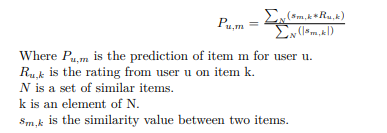

4. Post procesamiento

Filtrar las recomendaciones predichas en forma descendente para tener el top de juegos recomendados, top 40.

Filtrar los juegos que el usuario ya ha jugado y hecho reseña.

5. Evaluación

Usando la métrica RMSE comparar con los modelos implementados anteriormente, usando la siguiente formula:

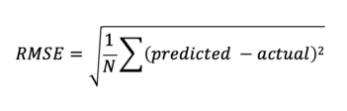